In [ ]:
import importlib
from mkids import TopSoc
import numpy as np
import matplotlib.pyplot as plt
import Scan
import pickle
soc = TopSoc(force_init_clks=False)

In [2]:
print("ADCs ", soc.adcs)
print("DACs ", soc.dacs)

ADCs  {'20': {'fs': 2457.6, 'f_fabric': 307.2}}
DACs  {'20': {'fs': 4915.2, 'f_fabric': 307.2}}


In [3]:
adcKey = list(soc.adcs.keys())[0]
fsAdc = soc.adcs[adcKey]['fs']
dacKey = list(soc.dacs.keys())[0]
# Here is that call to configure for the pfb out:
# self.pfb_out.configure(self.dacs[self.dacChannel]['fs']/4, self.mixer, self.dacChannel)
fsDac = soc.dacs[dacKey]['fs']/4
print("fsAdc, fsDac =",fsAdc, fsDac)
fnAdc = fsAdc/2
fnDac = fsDac/2
print("fnAdc, fnDac =",fnAdc, fnDac)



fsAdc, fsDac = 2457.6 1228.8
fnAdc, fnDac = 1228.8 614.4


In [4]:
def fMeasFromFGen(fn, fGen, nZone):
    if np.mod(nZone,2):
        #print(" ODD nZone =",nZone)
        fMeas = (nZone-1)*fn + fGen
    else:
        #print("EVEN nZone =",nZone)
        fMeas = nZone*fn - fGen
    return fMeas

def fGenFromFMeas(fn, fMeas):
    nZone = int(fMeas/fn) + 1
    if np.mod(nZone,2):
        #print(" ODD nZone =",nZone)
        fGen = fMeas - (nZone-1)*fn
    else:
        #print("EVEN nZone =",nZone)
        fGen = nZone*fn - fMeas
    return fGen

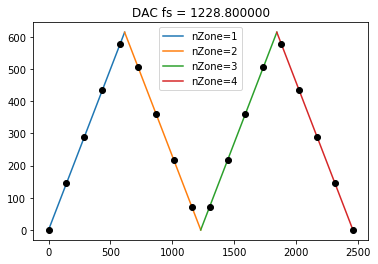

In [5]:
fn = fnDac
fGens = np.linspace(0,fn, 100)
for nZone in [1,2,3,4]:
    fMeas = np.zeros(len(fGens))
    for i,fGen in enumerate(fGens):
        fMeas[i] = fMeasFromFGen(fn, fGen, nZone)
    plt.plot(fMeas,fGens, label="nZone=%d"%nZone)
plt.legend()
fMeass = np.linspace(0,nZone*fn, 18)
fGens = np.zeros(len(fMeass))
for i,fMeas in enumerate(fMeass):
    fGens[i] =  fGenFromFMeas(fn, fMeas)
plt.plot(fMeass, fGens, 'ko')
_ =plt.title("DAC fs = %f"%fsDac)

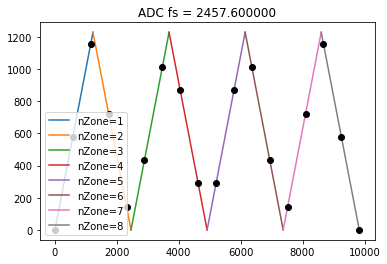

In [6]:
fn = fnAdc
fGens = np.linspace(0,fn, 100)
for nZone in [1,2,3,4,5,6,7,8]:
    fMeas = np.zeros(len(fGens))
    for i,fGen in enumerate(fGens):
        fMeas[i] = fMeasFromFGen(fn, fGen, nZone)
    plt.plot(fMeas,fGens, label="nZone=%d"%nZone)
plt.legend()
fMeass = np.linspace(0,nZone*fn, 18)
fGens = np.zeros(len(fMeass))
for i,fMeas in enumerate(fMeass):
    fGens[i] =  fGenFromFMeas(fn, fMeas)
plt.plot(fMeass, fGens, 'ko')
_ =plt.title("ADC fs = %f"%fsAdc)

In [7]:
scan = Scan.Scan(soc)

In [8]:
fMixer = 14024
soc.set_mixer(fMixer)

14024.000024414063

In [9]:

print("output")
print("fsDac =",fsDac)
print("soc.fsOut =",soc.fsOut)
print("soc.pf_out.fs =",soc.pfb_out.fs)
print("input")
print("fsAdc =",fsAdc)
print("soc.fsIn =",soc.fsIn)

output
fsDac = 1228.8
soc.fsOut = 1228.8
soc.pf_out.fs = 1228.8
input
fsAdc = 2457.6
soc.fsIn = 2457.6


In [10]:
# Let's set fMixer to be the input Nyquist frequency minus 1/4 ouput bandwidth
outputBandwidth = soc.nOutCh*soc.fcOut
print("outputBandwidth =",outputBandwidth)
inputNyquist = soc.fsIn/2
print("inputNyquist =",inputNyquist)
fMixer = soc.fsIn/2 - outputBandwidth/4
print("fMixer = ",fMixer)
soc.set_mixer(fMixer)

outputBandwidth = 1228.8
inputNyquist = 1228.8
fMixer =  921.5999999999999


921.5999999999999

In [11]:
fMixer = 1000
soc.set_mixer(fMixer)
fTone = fMixer + 12.345
outCh = soc.outFreq2ch(fTone)
inCh = soc.inFreq2ch(fTone)
print("fMixer=%.2f fTone=%.2f outCh=%d inCh=%d"%(fMixer, fTone, outCh, inCh))

fMixer=1000.00 fTone=1012.35 outCh=5 inCh=332


In [12]:
importlib.reload(Scan)
scan = Scan.Scan(soc)
def setAndRead(fTone, average=False, verbose=False, outsel="product"):
    scan.setTones(np.array([fTone]), np.array([0.9]), np.array([0.0]))
    scan.prepRead(decimation=2, outsel=outsel)
    xs = scan.readAndUnpack(nt=1, nsamp=10000, iBegin=1000, average=average)
    if verbose:
        f = scan.toneFreqs[0]
        outCh = scan.outChs[0]
        outDds = scan.outDds[0]
        inCh = scan.inChs[0]
        inOffset = scan.inOffsets[0]
        ntran = scan.ntranByTone[0]
        stream = scan.streamByTone[0]
        print(" f=%8.3f  outCh=%3d  outDds=%+6.3f  inCh=%4d   inOffset=%+6.3f   ntran=%4d   stream=%1d"%(fTone, outCh, outDds, inCh, inOffset, ntran, stream))
    return xs
#x = setAndRead(fTone, verbose=True)


In [13]:
freqs = fTone+2.4*np.arange(30)
for f in freqs:
    x = setAndRead(f, verbose=True)

 f=1012.345  outCh=  5  outDds=+0.345  inCh= 332   inOffset=-0.455   ntran=  41   stream=4
 f=1014.745  outCh=  6  outDds=+0.345  inCh= 334   inOffset=-0.455   ntran=  41   stream=6
 f=1017.145  outCh=  7  outDds=+0.345  inCh= 336   inOffset=-0.455   ntran=  42   stream=0
 f=1019.545  outCh=  8  outDds=+0.345  inCh= 338   inOffset=-0.455   ntran=  42   stream=2
 f=1021.945  outCh=  9  outDds=+0.345  inCh= 340   inOffset=-0.455   ntran=  42   stream=4
 f=1024.345  outCh= 10  outDds=+0.345  inCh= 342   inOffset=-0.455   ntran=  42   stream=6
 f=1026.745  outCh= 11  outDds=+0.345  inCh= 344   inOffset=-0.455   ntran=  43   stream=0
 f=1029.145  outCh= 12  outDds=+0.345  inCh= 346   inOffset=-0.455   ntran=  43   stream=2
 f=1031.545  outCh= 13  outDds=+0.345  inCh= 348   inOffset=-0.455   ntran=  43   stream=4
 f=1033.945  outCh= 14  outDds=+0.345  inCh= 350   inOffset=-0.455   ntran=  43   stream=6
 f=1036.345  outCh= 15  outDds=+0.345  inCh= 352   inOffset=-0.455   ntran=  44   stream=0

Text(0.5, 1.0, 'fMix=1000.00 fTone=1012.35')

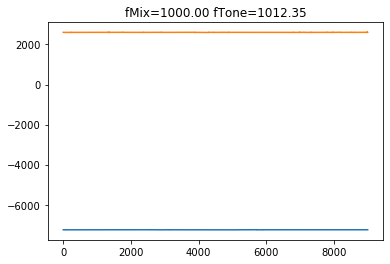

In [14]:
plt.plot(np.real(x[0][0]))
plt.plot(np.imag(x[0][0]))
plt.title("fMix=%.2f fTone=%.2f"%(scan.soc.get_mixer(), fTone))

In [15]:
freqs = fTone+2.4*np.arange(200)
amps = np.zeros(len(freqs))
for i,freq in enumerate(freqs):
    x = setAndRead(freq, verbose=True)
    amp = np.abs(x[0][0].mean())
    amps[i] = amp

 f=1012.345  outCh=  5  outDds=+0.345  inCh= 332   inOffset=-0.455   ntran=  41   stream=4
 f=1014.745  outCh=  6  outDds=+0.345  inCh= 334   inOffset=-0.455   ntran=  41   stream=6
 f=1017.145  outCh=  7  outDds=+0.345  inCh= 336   inOffset=-0.455   ntran=  42   stream=0
 f=1019.545  outCh=  8  outDds=+0.345  inCh= 338   inOffset=-0.455   ntran=  42   stream=2
 f=1021.945  outCh=  9  outDds=+0.345  inCh= 340   inOffset=-0.455   ntran=  42   stream=4
 f=1024.345  outCh= 10  outDds=+0.345  inCh= 342   inOffset=-0.455   ntran=  42   stream=6
 f=1026.745  outCh= 11  outDds=+0.345  inCh= 344   inOffset=-0.455   ntran=  43   stream=0
 f=1029.145  outCh= 12  outDds=+0.345  inCh= 346   inOffset=-0.455   ntran=  43   stream=2
 f=1031.545  outCh= 13  outDds=+0.345  inCh= 348   inOffset=-0.455   ntran=  43   stream=4
 f=1033.945  outCh= 14  outDds=+0.345  inCh= 350   inOffset=-0.455   ntran=  43   stream=6
 f=1036.345  outCh= 15  outDds=+0.345  inCh= 352   inOffset=-0.455   ntran=  44   stream=0

 f=1240.345  outCh=100  outDds=+0.345  inCh= 522   inOffset=-0.455   ntran=  65   stream=2
 f=1242.745  outCh=101  outDds=+0.345  inCh= 524   inOffset=-0.455   ntran=  65   stream=4
 f=1245.145  outCh=102  outDds=+0.345  inCh= 526   inOffset=-0.455   ntran=  65   stream=6
 f=1247.545  outCh=103  outDds=+0.345  inCh= 528   inOffset=-0.455   ntran=  66   stream=0
 f=1249.945  outCh=104  outDds=+0.345  inCh= 530   inOffset=-0.455   ntran=  66   stream=2
 f=1252.345  outCh=105  outDds=+0.345  inCh= 532   inOffset=-0.455   ntran=  66   stream=4
 f=1254.745  outCh=106  outDds=+0.345  inCh= 534   inOffset=-0.455   ntran=  66   stream=6
 f=1257.145  outCh=107  outDds=+0.345  inCh= 536   inOffset=-0.455   ntran=  67   stream=0
 f=1259.545  outCh=108  outDds=+0.345  inCh= 538   inOffset=-0.455   ntran=  67   stream=2
 f=1261.945  outCh=109  outDds=+0.345  inCh= 540   inOffset=-0.455   ntran=  67   stream=4
 f=1264.345  outCh=110  outDds=+0.345  inCh= 542   inOffset=-0.455   ntran=  67   stream=6

 f=1470.745  outCh=196  outDds=+0.345  inCh= 714   inOffset=-0.455   ntran=  89   stream=2
 f=1473.145  outCh=197  outDds=+0.345  inCh= 716   inOffset=-0.455   ntran=  89   stream=4
 f=1475.545  outCh=198  outDds=+0.345  inCh= 718   inOffset=-0.455   ntran=  89   stream=6
 f=1477.945  outCh=199  outDds=+0.345  inCh= 720   inOffset=-0.455   ntran=  90   stream=0
 f=1480.345  outCh=200  outDds=+0.345  inCh= 722   inOffset=-0.455   ntran=  90   stream=2
 f=1482.745  outCh=201  outDds=+0.345  inCh= 724   inOffset=-0.455   ntran=  90   stream=4
 f=1485.145  outCh=202  outDds=+0.345  inCh= 726   inOffset=-0.455   ntran=  90   stream=6
 f=1487.545  outCh=203  outDds=+0.345  inCh= 728   inOffset=-0.455   ntran=  91   stream=0
 f=1489.945  outCh=204  outDds=+0.345  inCh= 730   inOffset=-0.455   ntran=  91   stream=2


In [16]:
freq = freqs[190]
x = setAndRead(freq, verbose=True)
amp = np.abs(x[0][0].mean())
print(amp)

 f=1468.345  outCh=195  outDds=+0.345  inCh= 712   inOffset=-0.455   ntran=  89   stream=0
38.00536832531965


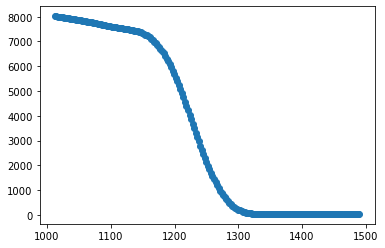

In [17]:
plt.plot(freqs,amps, '-o')
#plt.axvline(soc.fsIn/2, c='r')

In [ ]:
nTones = 40
freqs = fTone + 12*np.arange(nTones)
amps = 0.9*np.ones(nTones)/nTones
fis = 0.1*np.arange(nTones)
scan.setTones(freqs, amps, fis)
print(freqs)

In [ ]:
freqs,amps

In [ ]:
help(scan.setTones)

In [ ]:
plt.plot(freqs,amps, '-o')
plt.axvline(soc.fsIn/2, c='r')


In [ ]:
freqs = 2047+0.1*np.arange(100)
amps = np.zeros(len(freqs))
for i,freq in enumerate(freqs):
    x = setAndRead(freq, verbose=True)
    amp = np.abs(x[0][0].mean())
    amps[i] = amp
plt.plot(freqs,amps, '-o')
plt.axvline(soc.fsIn/2, c='r')


In [ ]:
freqs = 2045+2*np.arange(100)
amps = np.zeros(len(freqs))
for i,freq in enumerate(freqs):
    x = setAndRead(freq, verbose=True)
    amp = np.abs(x[0][0].mean())
    amps[i] = amp
plt.plot(freqs,amps, '-o')
plt.axvline(soc.fsIn/2, c='r')


In [ ]:
fMixer = 614
soc.set_mixer(fMixer)
freqs = np.linspace(800,900,50)

amps = np.zeros(len(freqs))
for i,freq in enumerate(freqs):
    print(i, end=" ")
    x = setAndRead(freq, verbose=True)
    amp = np.abs(x[0][0].mean())
    amps[i] = amp

In [ ]:
plt.plot(freqs,amps, '-o')
#plt.xlim((997, 998))

In [ ]:
plt.plot(freqs,amps, '-o')
plt.xlim((1007, 1008))

In [ ]:
importlib.reload(Scan)
scan = Scan.Scan(soc)
fMixer = 614
freq = 820
inCh,inOff = soc.inFreq2chOffset(freq)
print(inCh, inOff)
inFCenter = soc.inCh2FreqCenter(inCh)
print(inFCenter)
soc.set_mixer(fMixer)
x = setAndRead(freq, verbose=True, average=False, outsel="dds")

In [ ]:
from numpy.fft import fft, fftshift
from scipy.signal import welch
xc = np.array(x[0][0])
xc.shape
fs = soc.pfb_in.get_fb()/soc.ddscic.get_decimate()
F, Y = fftshift(welch(xc,
                          fs,
                          return_onesided=False,
                          detrend=False,
                          nperseg=512), axes=1)


In [ ]:
plt.plot((F+inFCenter)/1000,10*np.log10(Y))
plt.axvline(freq/1000, color='r')

In [ ]:
importlib.reload(Scan)
scan = Scan.Scan(soc)
fMixer = 614
freq = 1000.06
inCh,inOff = soc.inFreq2chOffset(freq)
print(inCh, inOff)
inFCenter = soc.inCh2FreqCenter(inCh)
print(inFCenter)
soc.set_mixer(fMixer)
x = setAndRead(freq, verbose=True, average=False, outsel="product")

In [ ]:
xc = np.array(x[0][0])
xc.shape
fs = soc.pfb_in.get_fb()/soc.ddscic.get_decimate()
F, Y = fftshift(welch(xc,
                          fs,
                          return_onesided=False,
                          detrend=False,
                          nperseg=512), axes=1)


In [ ]:
plt.plot((F)/1000,10*np.log10(Y))

In [ ]:
plt.plot(np.real(xc))
plt.plot(np.imag(xc))
print(np.abs(xc.mean()))